In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
from tqdm import tqdm
import scipy as sp
from copy import deepcopy 

# LISA tools
from lisatools.utils.constants import *
from lisatools.sensitivity  import AE1SensitivityMatrix, AET1SensitivityMatrix

# BBHX: Suppress the print statements from the BBHX module like: "No CuPy or GPU PhenomHM module"
# This is done to avoid cluttering the output when running sp.optimize.differential_evolution
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

with suppress_stdout():
    from bbhx.waveformbuild import BBHWaveformFD

# My modules
from tools.LISASimulator import LISASimulator
from tools.time_freq_likelihood import TimeFreqLikelihood
from tools.likelihood import get_dh, get_hh, TimeFreqSNR
import tools.likelihood as likelihood
from tools.MBHB_differential_evolution import MBHB_finder_time_frequency, MBHB_finder_lisatools, MBHB_finder_frequency_domain, transform_bbhx_to_parameters, transform_parameters_to_bbhx
from tools.save_and_load_DE import save_de_results, load_de_results

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

11


In [3]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 20 * PC_SI * 1e9  # distance in Gpc
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(length=1024, direct=False, fill=True, squeeze=False, modes=modes)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, waveform_kwargs=waveform_kwargs)
waveform_kwargs.update(freqs=f_array)

print(sim.SNR_optimal()[0])

719.096881292466


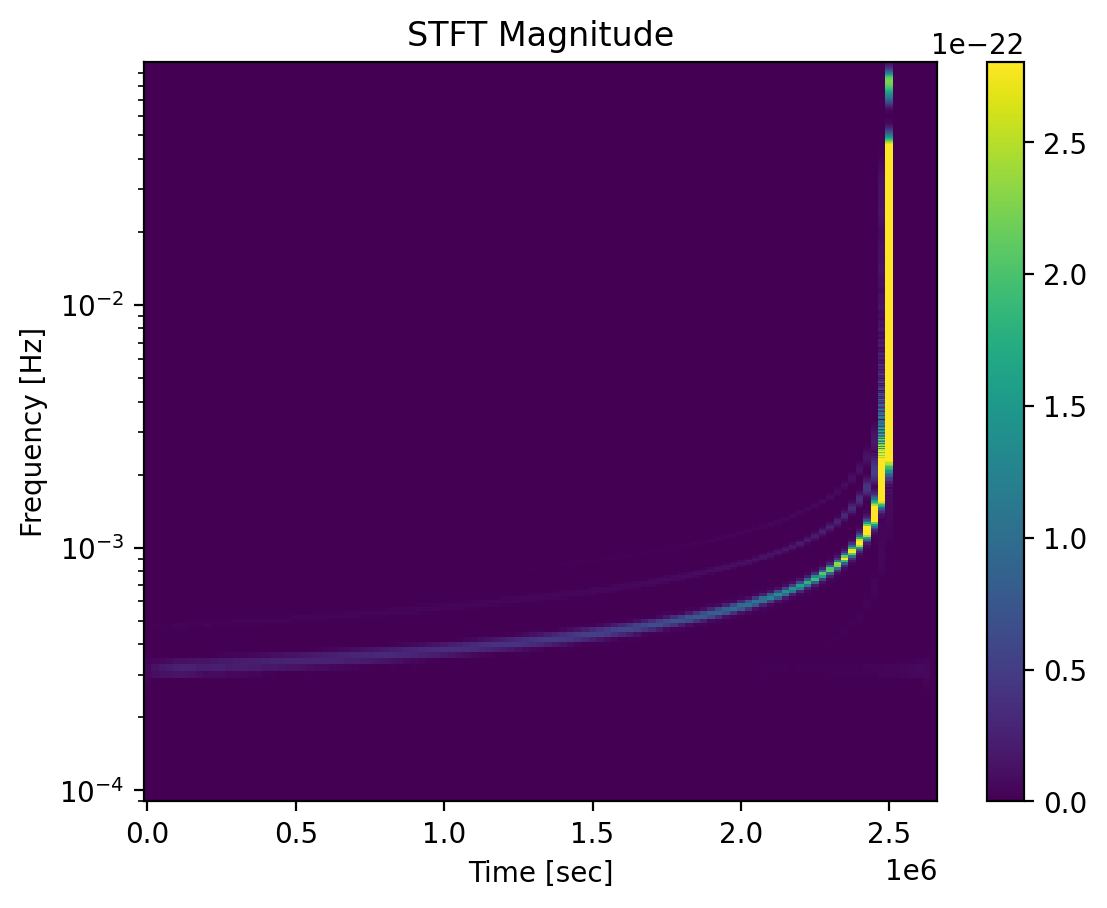

In [4]:
f, t, Zxx = sp.signal.stft(sim.signal_t[0][0], fs=1/sim.dt, nperseg=10000)
max_freq_idx = np.searchsorted(f, 0.1)
min_freq_idx = np.searchsorted(f, 1e-4)

plt.figure()
plt.pcolormesh(t, f[min_freq_idx:max_freq_idx], np.abs(Zxx[min_freq_idx:max_freq_idx]), vmin=0, 
            vmax= np.max(np.abs(Zxx[min_freq_idx:max_freq_idx]))/10)
plt.yscale('log')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

## Pre-Merger

In [5]:
# Not doing the premerger now to see if the code works better with the merger included
hours_before_merger = 20
time_before_merger = hours_before_merger*60*60
cutoff_time = t_ref - time_before_merger
max_time = t_ref + (24 - hours_before_merger)*60*60

def pre_merger(gravitational_wave_data_t, time_before_merger, t_ref, t_array):
        cutoff_time = t_ref - time_before_merger
        cutoff_index = np.searchsorted(t_array, cutoff_time)
        data_t_truncated = gravitational_wave_data_t[:, :cutoff_index]
        return data_t_truncated, cutoff_index

data_t_truncated,   cutoff_index =  pre_merger(data_t, time_before_merger, t_ref, t_array)
signal_t_truncated, cutoff_index =  pre_merger(sim.signal_t[0], time_before_merger, t_ref, t_array)

# Differential Evolution Analysis

In [6]:
boundaries = {}
boundaries['Total_Mass'] = [np.log(1e5), np.log(1e6)]   
boundaries['Mass_Ratio'] = [0.05, 0.999999]
boundaries['Spin1'] = [-1, 1]
boundaries['Spin2'] = [-1, 1]
boundaries['Distance'] = [1, 50] # in GPc i.e. dL / (PC_SI * 1e9)
boundaries['Phase'] = [0.0, 2 * np.pi]
boundaries['cos(Inclination)'] = [-1, 1]
boundaries['Ecliptic_Longitude'] = [0, 2*np.pi]
boundaries['sin(Ecliptic_Latitude)'] = [-1, 1]
boundaries['Polarization'] = [0, np.pi]
#boundaries['Coalescence_Time'] = [cutoff_time, max_time]  
boundaries['Coalescence_Time'] = [0, max_time - cutoff_time]

In [7]:
number_of_searches = 1

differential_evolution_kwargs = {
    'strategy': 'best1bin',
    'popsize': 15,
    'tol': 1e-8,
    'maxiter': 5,
    'recombination': 0.9,
    'mutation': (0.4, 0.8),
    'polish': False,
    'disp': True,
    'workers': -1,
    'updating': 'deferred',
    'init': 'latinhypercube',
}

fixed_parameters = {
    'Total_Mass': np.log(m1 + m2),
    'Mass_Ratio': m2 / m1,
    'Spin1': a1,
    'Spin2': a2,
    'Distance': boundaries['Distance'][0] + 0.5 * (boundaries['Distance'][1] - boundaries['Distance'][0]), # Always include distance in fixed parameters
    'Phase': phi_ref,
    'cos(Inclination)': np.cos(inc),
    #'Ecliptic_Longitude': lam,
    'sin(Ecliptic_Latitude)': np.sin(beta),
    'Polarization': psi,
    'Coalescence_Time': t_ref-cutoff_time,
}

# Time Frequency Domain

In [8]:
analysis = TimeFreqSNR(
    data_t_truncated,
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=True
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters, waveform_kwargs=waveform_kwargs)
new_distance = dist /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)

-0.03669323539758024 -0.0018346617698790121
True distance       =  19.999999999999996 Gpc
Dist from Amplitude =  19.963306764602418 Gpc
SNR calculated      =  0.04196816352063024


In [10]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
DifferentialEvolution_time_frequency_1 = MBHB_finder_time_frequency(
    data_t = data_t_truncated,
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=True,
    cutoff_index=cutoff_index,
    cutoff_time=cutoff_time,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_1.get_stft_of_data()
found_parameters_tf_1, found_snr_found_tf_1, results_tf_1, parameters_history_1 = DifferentialEvolution_time_frequency_1.find_MBHB(number_of_searches=number_of_searches,
                                                                                                                                   differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                                                                                   fixed_parameters=None)

No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.


In [ ]:
save_de_results(
    found_parameters_tf_1,
    found_snr_found_tf_1,
    SNR,
    results_tf_1,
    parameters_history_1,
    folder_name="euler_output",
    filename_prefix="tf_run"
)

Saved results to euler_output/tf_run_20250709_154147.npz


In [21]:
print(DifferentialEvolution_time_frequency_1)
print("Found parameters (Time-Frequency):", found_parameters_tf_1)
print("Found SNR:", found_snr_found_tf_1, "True SNR:", SNR)
print("Parameters history (Time-Frequency):", parameters_history_1)
print("Results (Time-Frequency):", results_tf_1)


Index Parameter                 Lower Bound    Found 1             Found 2             True                 Upper Bound     Status    
--------------------------------------------------------------------------------------------------------------------------------------
0     Total_Mass                11.5129        12.1953             13.0008             13.017               13.8155         variable  
1     Mass_Ratio                0.05           0.0774772           0.57536             0.5                  0.999999        variable  
2     Spin1                     -1             0.121283            0.56965             0.2                  1               variable  
3     Spin2                     -1             0.97003             -0.405141           0.4                  1               variable  
4     Distance                  1              106.2               35.8888             20                   50              variable  
5     Phase                     0              1.13554 

In [20]:
DifferentialEvolution_time_frequency_1.found_parameters_11_all

array([[ 1.21952695e+01,  7.74772291e-02,  1.21283290e-01,
         9.70029700e-01,  1.06200464e+02,  1.13553801e+00,
        -6.67694853e-01,  2.53982064e+00, -6.88329732e-01,
         2.57556014e+00,  1.29723284e+02],
       [ 1.30008466e+01,  5.75359844e-01,  5.69650167e-01,
        -4.05140663e-01,  3.58888251e+01,  2.73180378e+00,
         7.90753670e-01,  1.72042405e+00,  8.38584851e-01,
         1.13954036e+00,  7.15008705e+04]])

In [17]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
DifferentialEvolution_time_frequency_2 = MBHB_finder_time_frequency(
    data_t = data_t_truncated,
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=True,
    cutoff_index=cutoff_index,
    cutoff_time=cutoff_time,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_2.get_stft_of_data()
differential_evolution_kwargs_2 = {
    'strategy': 'best1bin',
    'popsize': 15,
    'tol': 1e-8,
    'maxiter': 200,
    'recombination': 0.9,
    'mutation': (0.4, 0.8),
    'polish': True,
    'disp': True,
    'workers': -1,
    'updating': 'deferred',
    'init': 'latinhypercube',
}


found_parameters_tf_2, found_snr_found_tf_2, results_tf_2, parameters_history_2 = DifferentialEvolution_time_frequency_2.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs_2, 
                                                                             fixed_parameters=fixed_parameters)

time SNR  0.27
initial guess 0.003980823156079058
No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomH

In [18]:
print(DifferentialEvolution_time_frequency_2)
print(results_tf_2)

Index Parameter                 Lower Bound    Found 1             True                 Upper Bound     Status    
------------------------------------------------------------------------------------------------------------------
0     Total_Mass                11.5129        13.017              13.017               13.3047         fixed     
1     Mass_Ratio                0.05           0.5                 0.5                  0.999999        fixed     
2     Spin1                     -1             0.2                 0.2                  1               fixed     
3     Spin2                     -1             0.4                 0.4                  1               fixed     
4     Distance                  1              3.99695             4                    10              variable  
5     Phase                     0              1.5708              1.5708               6.28319         fixed     
6     cos(Inclination)          -1             0.5                 0.5          

In [ ]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
DifferentialEvolution_time_frequency_3 = MBHB_finder_time_frequency(
    data_t = data_t_truncated,
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=True,
    cutoff_index=cutoff_index,
    cutoff_time=cutoff_time,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_3.get_stft_of_data()

found_parameters_tf_3, found_snr_found_tf_3, results_tf_3 = DifferentialEvolution_time_frequency_3.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_parameters=fixed_parameters)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
print(DifferentialEvolution_time_frequency_3)
print(results_tf_3)

Index Parameter                 Lower Bound    Found 1             True                 Upper Bound     Status    
------------------------------------------------------------------------------------------------------------------
0     Total_Mass                100000         445806              450000               600000          variable  
1     Mass_Ratio                0.05           0.525472            0.5                  0.999999        variable  
2     Spin1                     -1             -0.0388861          0.2                  1               variable  
3     Spin2                     -1             0.918805            0.4                  1               variable  
4     Distance                  1000           2429                4000                 10000           variable  
5     Phase                     0              4.83071             1.5708               6.28319         variable  
6     cos(Inclination)          -1             -0.419214           0.5          

In [ ]:
analysis = TimeFreqSNR(
    sim.signal_t[0],
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=False
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters, waveform_kwargs=waveform_kwargs)
new_distance = dist /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)

0.0 0.0
True distance       =  4.0 Gpc
Dist from Amplitude =  4.0 Gpc
SNR calculated      =  1.2772543789153916


In [ ]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
differential_evolution_kwargs_4 = {
    'strategy': 'best1exp',
    'popsize': 10,
    'tol': 1e-8,
    'maxiter': 1000,
    'recombination': 1,
    'mutation': (0.5, 1.0),
    'polish': True,
    'disp': True,
    'workers': -1,  # Use all available CPU cores
    'updating': 'deferred',
}

DifferentialEvolution_time_frequency_4 = MBHB_finder_time_frequency(
    data_t = sim.signal_t[0],
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=False,
    #cutoff_index=cutoff_index,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_4.get_stft_of_data()

found_parameters_tf_4, found_snr_found_tf_4, results_tf_4 = DifferentialEvolution_time_frequency_4.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs_4, 
                                                                             fixed_parameters=fixed_parameters)

time SNR  0.2
initial guess 0.027760634579982197
No CuPy
No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy or GPU response available.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM

In [ ]:
print(DifferentialEvolution_time_frequency_4)
print(results_tf_4)

Index Parameter                 Lower Bound    Found 1             True                 Upper Bound     Status    
------------------------------------------------------------------------------------------------------------------
0     Total_Mass                100000         418879              450000               600000          variable  
1     Mass_Ratio                0.05           0.999999            0.5                  0.999999        variable  
2     Spin1                     -1             0.178661            0.2                  1               variable  
3     Spin2                     -1             0.178659            0.4                  1               variable  
4     Distance                  1000           4325.18             4000                 10000           variable  
5     Phase                     0              2.56759             1.5708               6.28319         variable  
6     cos(Inclination)          -1             -0.514823           0.5          

In [ ]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
differential_evolution_kwargs_5 = {
    'strategy': 'randtobest1exp',
    'popsize': 10,
    'tol': 1e-8,
    'maxiter': 1000,
    'recombination': 1,
    'mutation': (0.5, 1.0),
    'polish': True,
    'disp': True,
    'workers': -1,  # Use all available CPU cores
    'updating': 'deferred',
}

DifferentialEvolution_time_frequency_5 = MBHB_finder_time_frequency(
    data_t = sim.signal_t[0],
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=False,
    #cutoff_index=cutoff_index,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_5.get_stft_of_data()

found_parameters_tf_5, found_snr_found_tf_5, results_tf_5 = DifferentialEvolution_time_frequency_5.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs_5, 
                                                                             fixed_parameters=fixed_parameters)

time SNR  0.2
initial guess 0.003294986272816304
No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM

In [ ]:
print(DifferentialEvolution_time_frequency_5)
print(results_tf_5)

Index Parameter                 Lower Bound    Found 1             True                 Upper Bound     Status    
------------------------------------------------------------------------------------------------------------------
0     Total_Mass                100000         450320              450000               600000          variable  
1     Mass_Ratio                0.05           0.498232            0.5                  0.999999        variable  
2     Spin1                     -1             0.202107            0.2                  1               variable  
3     Spin2                     -1             0.398259            0.4                  1               variable  
4     Distance                  1000           4082.77             4000                 10000           variable  
5     Phase                     0              1.57205             1.5708               6.28319         variable  
6     cos(Inclination)          -1             -0.5024             0.5          

In [ ]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
differential_evolution_kwargs_6 = {
    'strategy': 'best1bin',
    'popsize': 15,
    'tol': 1e-8,
    'maxiter': 1000,
    'recombination': 0.9,
    'mutation': (0.4, 0.8),
    'polish': True,
    'disp': True,
    'workers': -1,
    'updating': 'deferred',
    'init': 'latinhypercube',
}

DifferentialEvolution_time_frequency_6 = MBHB_finder_time_frequency(
    data_t = data_t,
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=False,
    #cutoff_index=cutoff_index,
    true_parameters=parameters,
)
DifferentialEvolution_time_frequency_6.get_stft_of_data()

found_parameters_tf_6, found_snr_found_tf_6, results_tf_6 = DifferentialEvolution_time_frequency_6.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs_6, 
                                                                             fixed_parameters=fixed_parameters)

time SNR  0.28
initial guess -0.010829483362928577
No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU Phenom

In [ ]:
print(DifferentialEvolution_time_frequency_6)
print(results_tf_6)

Index Parameter                 Lower Bound    Found 1             True                 Upper Bound     Status    
------------------------------------------------------------------------------------------------------------------
0     Total_Mass                100000         418844              450000               600000          variable  
1     Mass_Ratio                0.05           0.999999            0.5                  0.999999        variable  
2     Spin1                     -1             0.17892             0.2                  1               variable  
3     Spin2                     -1             0.178918            0.4                  1               variable  
4     Distance                  1000           4266.69             4000                 10000           variable  
5     Phase                     0              2.59243             1.5708               6.28319         variable  
6     cos(Inclination)          -1             -0.571439           0.5          

In [ ]:
analysis = TimeFreqSNR(
    data_t,
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=False
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters, waveform_kwargs=waveform_kwargs)
new_distance = dist /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)

# Without Noise = 1.2772543789153916
# With Noise    = 1.2772408586383

4.2342137742266475e-05 1.0585534435566619e-05
True distance       =  4.0 Gpc
Dist from Amplitude =  4.000042342137743 Gpc
SNR calculated      =  1.2772408586383


# Frequency Domain

In [ ]:
template = wave_gen(*parameters,**waveform_kwargs)[0, :2]

print(likelihood.template_snr(sim.signal_f[0], template, AE1SensitivityMatrix(f_array), df=sim.df))

hh = get_hh(template, AE1SensitivityMatrix(f_array), df=sim.df)
dh = get_dh(sim.signal_f[0], template, AE1SensitivityMatrix(f_array), df=sim.df)
amplitude = dh/hh
new_distance = dist /  amplitude

print( "Percentage diff     = ", (new_distance-dist)*100/dist , "%" )
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = " , dh/np.sqrt(hh))

In [ ]:
DifferentialEvolution_frequency_domain= MBHB_finder_frequency_domain(
    data_f=data_f,
    wave_gen=wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    true_parameters=parameters,
)

DifferentialEvolution_frequency_domain.prepare_data(f_array=f_array, df=sim.df)
found_parameters_fd, found_snr_found_fd, results_fd = DifferentialEvolution_frequency_domain.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_parameters=fixed_parameters)
# The number of messages like "No CuPy or GPU PhenomHM module" you see is exactly equal to the number of workers used. On this macbook, it has 11 cores, so there are 11 messages. Imma just live with this

In [ ]:
print(DifferentialEvolution_frequency_domain), results_fd

In [ ]:
DifferentialEvolution_lisatools= MBHB_finder_lisatools(
    data_f=data_f,
    sens_mat=AE1SensitivityMatrix(f=f_array),
    wave_gen=wave_gen,
    waveform_kwargs=waveform_kwargs,
    f_array=f_array,
    boundaries=boundaries,
    true_parameters=parameters,
)


DifferentialEvolution_lisatools.get_analysis_container_of_data()

found_parameters_lisatools, found_snr_found_lisatools, results_lisatools = DifferentialEvolution_lisatools.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_parameters=fixed_parameters)
# The number of messages like "No CuPy or GPU PhenomHM module" you see is exactly equal to the number of workers used. On this macbook, it has 11 cores, so there are 11 messages. Imma just live with this

In [ ]:
print(DifferentialEvolution_lisatools)
print(results_lisatools)

- The reason why the distance estimate can be so bad (sometimes even outside the priors) is because it is calculated from the amplitude that is calculated with a template generated by the other found parameters
- The other found parameters don't have to be close to the true parameters, unless you run it for longer
- With low tolarance, high popsize, and high maxiter, it works properly but takes a long time to run

In [ ]:
import os
os.system("say 'Computation is done!'")

# The SNR does not depend on the distance. 
Change the guess_distance to see that the SNR is the same. The distance is calculated based on the amplitude.
- This only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that

In [ ]:
guess_distance = dist * 1000
signal_with_which_to_test_this = sim.signal_f[0] #data_f
template = wave_gen(
    m1,
    m2,
    a1,
    a2,
    guess_distance, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    **waveform_kwargs
)
template = template[0, :2]
print(likelihood.template_snr(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df))

hh = get_hh(template, AE1SensitivityMatrix(f_array), df=sim.df)
dh = get_dh(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df)
amplitude = dh/hh
new_distance = guess_distance /  amplitude

print( "Percentage diff     = ", (new_distance-dist)*100/dist , "%" )
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = " , dh/np.sqrt(hh))

The SNR also does not change with the time-frequency SNR with pre-merger. Change guess_distance and see that nothing changes.
- Again, this only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that.
- But it's good that using time-freq SNR also works to get the distance.
- Change the value of, say, m1 drastically and see that the distance estimate from the equation is awful, which makes sense.

In [ ]:
guess_distance = dist 
parameters_new = [
    m1*(1),  # Slightly change m1 to see the effect
    m2,
    a1*(1),  # Slightly change a1 to see the effect
    a2,
    guess_distance,
    phi_ref,
    f_ref,
    inc*(1 ),
    lam,
    beta,
    psi,
    t_ref
]
analysis = TimeFreqSNR(
    data_t_truncated,
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=True
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters_new, waveform_kwargs=waveform_kwargs)
new_distance = guess_distance /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)